In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# อ่านข้อมูลจากไฟล์ CSV
df = pd.read_csv('cleaned_data.csv')

# แปลง timestamp เป็น datetime และตัดมิลลิวินาทีออก
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce').dt.strftime('%Y-%m-%d %H:%M:%S')
df['timestamp'] = pd.to_datetime(df['timestamp'])  # แปลงกลับเป็น datetime แบบไม่มีมิลลิวินาที

# ตั้งค่า timestamp เป็น index
df.set_index('timestamp', inplace=True)


# ลบค่าที่ซ้ำกัน
df = df[~df.index.duplicated(keep="last")]

# เติม timestamp ที่ขาดให้ครบทุกชั่วโมง
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
df = df.reindex(full_range)

# เติมค่าที่ขาดด้วย Spline Interpolation
df.interpolate(method='spline', order=2, inplace=True)

# กรองข้อมูล
df = df[(df['pm_2_5'] >= 0) & (df['pm_2_5'] <= 100)]
df = df[(df['pm_2_5_sp'] >= 0) & (df['pm_2_5_sp'] <= 180)]

# Smooth ข้อมูล (ลด Noise)
df['pm_2_5'] = df['pm_2_5'].rolling(window=3, center=True).mean()

# เลือกข้อมูล
data = df['pm_2_5']

# แบ่ง Train/Test
train_data = data[:-1680]
test_data = data[-1680:]

# สร้างและฝึกโมเดล SARIMAX
model = SARIMAX(train_data, order=(3, 1, 3), seasonal_order=(1, 1, 2, 24))
model_fit = model.fit(disp=False)

# ทำนาย
forecast_steps = 1680
forecast = model_fit.forecast(steps=forecast_steps)

# สร้างช่วงเวลาใหม่
forecast_index = pd.date_range(start=train_data.index[-1], periods=forecast_steps + 1, freq='H')[1:]
forecast.index = forecast_index

# ประเมินผล
mse = mean_squared_error(test_data, forecast)
mae = mean_absolute_error(test_data, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100
r2 = r2_score(test_data, forecast)
accuracy = 100 - mape

# แสดงผลการประเมิน
evaluation_results = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'MAPE', 'R²', 'Accuracy'],
    'Value': [mae, mse, rmse, mape, r2, accuracy]
})

print(evaluation_results)

# # แสดงผลการทำนาย
# plt.figure(figsize=(12, 6))
# plt.plot(train_data.index, train_data, label='Train Data')
# plt.plot(test_data.index, test_data, label='Test Data')
# plt.plot(forecast_index, forecast, label='Forecast', color='red')
# plt.legend()
# plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_36448\2296580155.py:26: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='spline', order=2, inplace=True)
c:\termproject1-2_cleandata\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\termproject1-2_cleandata\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


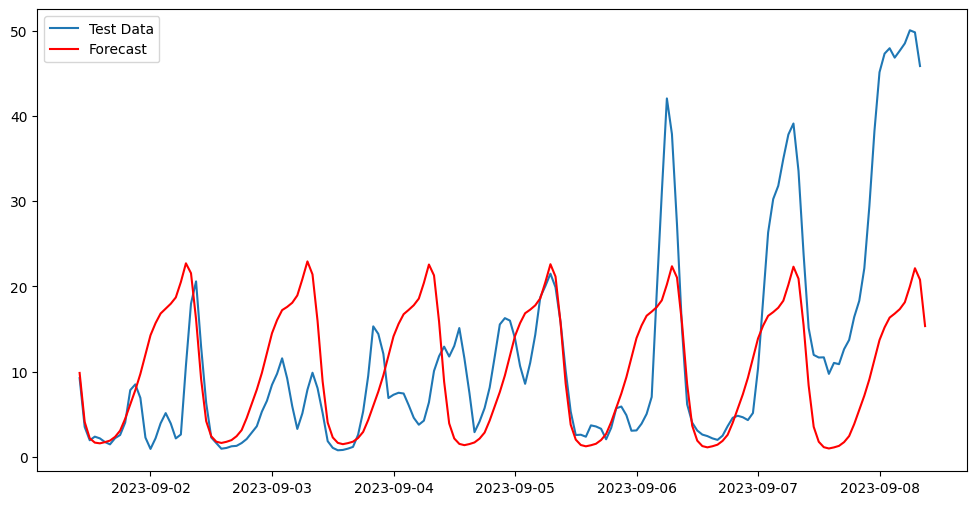

In [ ]:
# แสดงผลการทำนาย
plt.figure(figsize=(12, 6))
# plt.plot(train_data.index[-200:], train_data[-200:], label='Train Data')
plt.plot(test_data.index[-2000:], test_data[-2000:], label='Test Data')
plt.plot(forecast_index[-2000:], forecast[-2000:], label='Forecast', color='red')
plt.legend()
plt.show()